# **Rule of Thumb 1**: Don't Intentionally Retain the Hammer

Unlike traditional curling, blanking an end doesn’t allow you to retain the hammer.  To retain the hammer, you must actually lose one or several points.  When would a team ever be willing to do this?

Imagine it is the 7th end and the hammer team has a PP remaining.  It is very common to use a PP here, but if all goes well, the opponent will have the hammer in the last end of the game.  Allowing your opponent this ending control isn’t ideal, especially if they have a PP remaining which has the potential for a big, last-second score.  If any situation warrants a sacrifice to retain the PP, this is likely it.  In the few cases a team has elected for this sacrifice, the results were great.  Four teams had attempted this PP retention strategy: every time the team had a slight lead before sacrificing a point and proceeded to win the game.

Is this a viable strategy?  Or did these teams get lucky?

## **Imports and Load Data**

In [21]:
# imports
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import random
import numpy as np

In [22]:
# load Ends.csv from github
ends_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Ends.csv'
stones_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Stones.csv'

Ends = pd.read_csv(ends_path)
Stones = pd.read_csv(stones_path)

## **Data Transformations**

In [23]:
## Get which team has the hammer

# getting data from games is a bitch, so I'm gonna be a clever bastard and get it from stones
team_hammer = Stones[Stones['ShotID'].isin([7,8])][['CompetitionID', 'SessionID', 'GameID', 'EndID', 'ShotID', 'TeamID']]
# get the team with the hammer - or without
team_hammer['ShotID'] = team_hammer['ShotID'] - 7
team_hammer.rename(columns={'ShotID': 'Hammer'}, inplace=True)

In [24]:
## Merge onto main df
merged = pd.merge(Ends, team_hammer, on=['CompetitionID', 'SessionID', 'GameID', 'EndID', 'TeamID'])
merged['PP'] = merged['PowerPlay'].apply(lambda x: 0 if pd.isna(x) else 1)

In [25]:
def get_score_difference(group):
    """
    Computes the score difference for each team in a group (e.g., each end).
    ScoreDifference = team's score - opponent's score
    """
    if group.empty or len(group) != 2:
        # Skip if the group is empty or doesn't have exactly 2 teams
        print("Error")
        return group

    scores = group['Result'].values

    # Assign scores
    core_diff = [scores[0] - scores[1], scores[1] - scores[0]]

    # Assign to new column
    group['ScoreDifference'] = core_diff

    return group

In [26]:
df = merged.groupby(['CompetitionID', 'SessionID', 'GameID', 'EndID'], group_keys=False).apply(get_score_difference)

# Compute cumulative score difference within each GameID and TeamID
df['CumulativeScoreDifference'] = df.groupby(['CompetitionID', 'SessionID', 'GameID', 'TeamID'])['ScoreDifference'].cumsum()
df['SDLag'] = df['CumulativeScoreDifference'].shift(2)
df.loc[df['EndID'] == 1, 'SDLag'] = 0

/tmp/ipython-input-488546022.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = merged.groupby(['CompetitionID', 'SessionID', 'GameID', 'EndID'], group_keys=False).apply(get_score_difference)


In [27]:
## get if the PP has been used before
df = df.sort_values(['CompetitionID', 'SessionID', 'GameID', 'TeamID', 'EndID'])
df['PP_Remain'] = (
    df.groupby(['CompetitionID', 'SessionID', 'GameID', 'TeamID'])['PP']
      #.cumsum()
      .transform(lambda s: s.cumsum().shift(0))
      #.shift(fill_value=0)
      .gt(0)
      .astype(int)
)
# adjust to not count if the team elects to use it in the current round
df['PP_Remain'] = 1 - (df['PP_Remain'] - df['PP'])

## Scenarios where Hammer Team (with Powerplay Remaining) lost the 7th End

There are 4 instances where a hammer team chose not to use their remaining powerplay in the 7th end and then lost the end. Whether intentional or not, the hammer team then retained possession of the hammer for the final end, where they used their powerplay.

In [28]:
# Load Information about Competitions and Teams
comps_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Competition.csv'
teams_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Teams.csv'
games_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Games.csv'

# Create a dataframe to store Competition and Team information
Comps = pd.read_csv(comps_path)
Teams = pd.read_csv(teams_path)
Games = pd.read_csv(games_path)

In [29]:
# Find instances where PP_Remain == 1, PP == 1, Hammer == 1, EndID == 7, ScoreDifference < 0
lose_7th_scenarios = df[(df['PP_Remain'] == 1) & (df['PP'] == 0) & (df['Hammer'] == 1) & (df['EndID'] == 7) & (df['ScoreDifference'] < 0)].copy()

# Create a copy of the Scenarios where a team with a powerplay remaining lost in the 7th end
full_scenario = lose_7th_scenarios.copy()

for index, row in lose_7th_scenarios.iterrows():
    comp_id = row['CompetitionID']
    session_id = row['SessionID']
    game_id = row['GameID']
    team_id = row['TeamID']
    # retrieve the 8th end information
    end_8 = df[(df['CompetitionID'] == comp_id) & (df['SessionID'] == session_id) & (df['GameID'] == game_id) & (df['TeamID'] == team_id) & (df['EndID'] == 8)]
    full_scenario = pd.concat([full_scenario, end_8])

full_scenario = full_scenario.sort_values(['CompetitionID', 'SessionID', 'GameID', 'TeamID', 'EndID']).reset_index(drop=True)
full_scenario

# Retrieve Other Team Name, Final Score, and Winner from Games Dataframe
# Retrieve End 8 Information for given Team
for index, row in full_scenario.iterrows():
    # Retrieve end by end information for the game
    end_info = df[
        (df['CompetitionID'] == row['CompetitionID']) &
        (df['SessionID'] == row['SessionID']) &
        (df['GameID'] == row['GameID'])
    ]

    # Retrieve the opponent
    other_team_id = end_info[end_info['TeamID'] != row['TeamID']]['TeamID'].iloc[0]
    opponent = Teams[
        (Teams['TeamID'] == other_team_id) &
        (Teams['CompetitionID'] == row['CompetitionID'])
    ]['Name'].values[0]

    # Retrieve PP Remaining status for other team
    other_team_pp_remaining = df[
        (df['CompetitionID'] == row['CompetitionID']) &
        (df['SessionID'] == row['SessionID']) &
        (df['GameID'] == row['GameID']) &
        (df['TeamID'] == other_team_id) &
        (df['EndID'] == 8)
    ]['PP_Remain'].iloc[0]

    # Get game info and format score
    game_info = Games[
        (Games['CompetitionID'] == row['CompetitionID']) &
        (Games['SessionID'] == row['SessionID']) &
        (Games['GameID'] == row['GameID'])
    ].iloc[0]

    # Format the Score of the Game
    score = f"{max(game_info['ResultStr1'], game_info['ResultStr2'])}-{min(game_info['ResultStr1'], game_info['ResultStr2'])}"

    # Set values
    full_scenario.loc[index, ['Opponent', 'Score', 'Opp_PP_Remain']] = [opponent, score, other_team_pp_remaining]

In [30]:
# Rename columns
full_scenario = full_scenario.rename(columns={'ScoreDifference': 'EndResult', 'SDLag': 'Pre-End Score Margin', 'CumulativeScoreDifference': 'Post-End Score Margin', 'Name': 'TeamName', 'Opp_PP_Remain': 'PP Remaining?'})

# Merge with Competition and Teams Dataframe to get additional information on the scenario
full_scenario = full_scenario.merge(Comps[['CompetitionID', 'CompetitionName']], on='CompetitionID', how='left')
full_scenario = full_scenario.merge(Teams[['CompetitionID', 'TeamID', 'Name']], on=['CompetitionID', 'TeamID'], how = 'left')

full_scenario = full_scenario[['CompetitionName', 'SessionID', 'Name', 'Opponent', 'Score', 'EndID', 'PP', 'PP Remaining?', 'Hammer', 'Pre-End Score Margin', 'EndResult', 'Post-End Score Margin']]

# Clean Pre-End Score to just be an integer
full_scenario['Pre-End Score Margin'] = full_scenario['Pre-End Score Margin'].astype(int)

# Change PP_Remain: 1: True, 0: False
# Change 1: PP Used, 0: Normal End
full_scenario['PP Remaining?'] = full_scenario['PP Remaining?'].apply(lambda x: 'PP Remaining' if x == 1 else 'No PP Remaining')
full_scenario['PP'] = full_scenario['PP'].apply(lambda x: 'Powerplay' if x == 1 else 'Normal End')
full_scenario['Hammer'] = full_scenario['Hammer'].apply(lambda x: 'With Hammer' if x == 1 else 'Without Hammer')

full_scenario_grouped = full_scenario.set_index(['CompetitionName', 'SessionID', 'Name', 'Opponent', 'Score', 'EndID'])
full_scenario_grouped

PP  \
CompetitionName                               SessionID Name    Opponent      Score EndID               
World Mixed Doubles Curling Championship 2023 1         Denmark Estonia       7-6   7      Normal End   
                                                                                    8       Powerplay   
                                              13        Italy   Korea         6-3   7      Normal End   
                                                                                    8       Powerplay   
World Mixed Doubles Curling Championship 2024 6         Czechia New Zealand   8-6   7      Normal End   
                                                                                    8       Powerplay   
                                              14        Czechia United States 7-4   7      Normal End   
                                                                                    8       Powerplay   

                                                                                             PP Remaining?  \
CompetitionName                               SessionID Name    Opponent      Score EndID                    
World Mixed Doubles Curling Championship 2023 1         Denmark Estonia       7-6   7      No PP Remaining   
                                                                                    8      No PP Remaining   
                                              13        Italy   Korea         6-3   7      No PP Remaining   
                                                                                    8      No PP Remaining   
World Mixed Doubles Curling Championship 2024 6         Czechia New Zealand   8-6   7      No PP Remaining   
                                                                                    8      No PP Remaining   
                                              14        Czechia United States 7-4   7      No PP Remaining   
                                                                                    8      No PP Remaining   

                                                                                                Hammer  \
CompetitionName                               SessionID Name    Opponent      Score EndID                
World Mixed Doubles Curling Championship 2023 1         Denmark Estonia       7-6   7      With Hammer   
                                                                                    8      With Hammer   
                                              13        Italy   Korea         6-3   7      With Hammer   
                                                                                    8      With Hammer   
World Mixed Doubles Curling Championship 2024 6         Czechia New Zealand   8-6   7      With Hammer   
                                                                                    8      With Hammer   
                                              14        Czechia United States 7-4   7      With Hammer   
                                                                                    8      With Hammer   

                                                                                           Pre-End Score Margin  \
CompetitionName                               SessionID Name    Opponent      Score EndID                         
World Mixed Doubles Curling Championship 2023 1         Denmark Estonia       7-6   7                         1   
                                                                                    8                         0   
                                              13        Italy   Korea         6-3   7                         3   
                                                                                    8                         2   
World Mixed Doubles Curling Championship 2024 6         Czechia New Zealand   8-6   7                         1   
                                                                                 

In all four scenarios,
* The hammer team was **always leading**, with a score margin between 1 and 3 points beginning the 7th end.
* The hammer team then proceeded to lose 1 or 2 points in the 7th end
* The hammer team then retained the hammer and used their powerplay in the 8th end.
* The hammer team either **increased or maintained the same score margin** at the end of the game than before the 7th end.

Interestingly, **Czechia** employed this strategy every instance they were leading into the 7th end in the [2024 World Mixed Doubles Curling Championship](https://en.wikipedia.org/wiki/2024_World_Mixed_Doubles_Curling_Championship) and won both games.

## Testing the Strategy

Sacrificing a point limits upside potential, obviously, but the tradeoff could mean reducing the risk of your opponent scoring 2+ points (see Figure 2).  We hypothesized that this probably wouldn’t be desirable in a losing situation where you want to maximize your upside, but teams would benefit from capping their losses in a close game when they have a slight MOV advantage.

We created an experiment using ten-thousand bootstrapped samples which calculated the odds of winning a game.  To make this simulation easier to understand, imagine Team A playing against Team B.  For the situation where Team A elects to use a PP in the 7th end, two cases were tested: one where Team B had a PP remaining for the 8th end (Case A1), and another where they did not (Case A2).  These cases’ results were compared to the situation where Team A sacrifices 1-2 points in the 7th end to maintain control of the hammer in the 8th end (Case B).  Each case was separately tested when Team A was losing by >2 points, losing by 1-2 points, tied, winning by 1-2 points, and winning by >2 points.

In [31]:
df['cat'] = df['SDLag'].apply(lambda x: -2 if x <= -3 else -1 if x <= -1 else 0 if x == 0 else 1 if x <= 2 else 2)
def lookup(x):
    if x < -2:
        return -2
    elif x < 0:
        return -1
    elif x == 0:
        return 0
    elif x <= 2:
        return 1
    else:
        return 2

In [32]:
# case A1: team A uses PP in the 7th, B has a PP remaining
def bootstrap_PP_c1(base_list, case_one, case_two):
  # get random sample for round 7 from team A
  temp7 = random.choice(base_list)
  end7 = temp7[0]
  # make new category
  category = lookup(temp7[1] + temp7[0])

  # get value for round 8
  # if < 0, team A gets hammer again
  if end7 < 0:
    temp8 = random.choice(case_one[case_one['cat'] == category].values)
    end8 = temp8[0]
  # else, team B gets to go
  else:
    temp8 = random.choice(case_two[case_two['cat'] == category].values)
    end8 = -temp8[0]

  # get final score => end8 cumulative + end7 + end8
  final = temp7[1] + end7 + end8
  return final

In [33]:
# make empty data frame
case_A_one_df = pd.DataFrame()

# loop through categories
for i in range(-2, 3):
  # set up minimized input values
  base = df[(df['cat'] == i) & (df['PP'] == 1) & (df['EndID'].isin([6,7]))][['ScoreDifference', 'SDLag']].values
  case_one = df[(df['PP'] == 0) & (df['Hammer'] == 1) & (df['EndID'].isin([7,8]))][['ScoreDifference', 'cat']]
  case_two = df[(df['PP'] == 1) & (df['Hammer'] == 1) & (df['EndID'].isin([7,8]))][['ScoreDifference', 'cat']]

  # run the samples
  i_samples = pd.Series(
    [bootstrap_PP_c1(base, case_one, case_two) for _ in range(10000)]
  )

  # append to case
  case_A_one_df[f'{i}'] = i_samples

In [34]:
# make empty data frame
case_A_two_df = pd.DataFrame()

# case 2: Team A uses Power Play in the 7th, B does not have a Power Play remaining
# loop through categories
for i in range(-2, 3):
  # set up minimized input values
  base = df[(df['cat'] == i) & (df['PP'] == 1) & (df['EndID'].isin([6,7]))][['ScoreDifference', 'SDLag']].values
  case_one = df[(df['PP'] == 0) & (df['Hammer'] == 1) & (df['EndID'].isin([7,8]))][['ScoreDifference', 'cat']]
  case_two = df[(df['PP'] == 0) & (df['Hammer'] == 1) & (df['EndID'].isin([7,8]))][['ScoreDifference', 'cat']]

  # run the samples
  i_samples = pd.Series(
    [bootstrap_PP_c1(base, case_one, case_two) for _ in range(10000)]
  )

  # append to case
  case_A_two_df[f'{i}'] = i_samples

In [35]:
# case B: team A throws end 7, uses PP to comeback in end 8
def bootstrap_PP_c2(base_list, case_one):
  # get random sample for round 7 from team A
  temp7 = random.choice(base_list)
  # loss is going to draw from the 4 plays we know exist
  end7 = random.choice([-1, -1, -1, -2])
  # make new category
  category = lookup(temp7[1] + end7)

  # get random play
  temp8 = random.choice(case_one[case_one['cat'] == category].values)
  end8 = temp8[0]

  # get final score => end8 cumulative + end7 + end8
  final = temp7[1] + end7 + end8
  return final

In [36]:
# make empty data frame
case_B_df = pd.DataFrame()

# loop through score difference categories
for i in range(-2, 3):
  # set up minimized input values
  base = df[(df['cat'] == i) & (df['PP_Remain'] == 1) & (df['EndID'].isin([6,7]))][['ScoreDifference', 'SDLag']].values
  case_one = df[(df['PP'] == 1) & (df['EndID'].isin([7,8]))][['ScoreDifference', 'cat']]

  # run the samples
  i_samples = pd.Series(
    [bootstrap_PP_c2(base, case_one) for _ in range(10000)]
  )

  # append to case
  case_B_df[f'{i}'] = i_samples

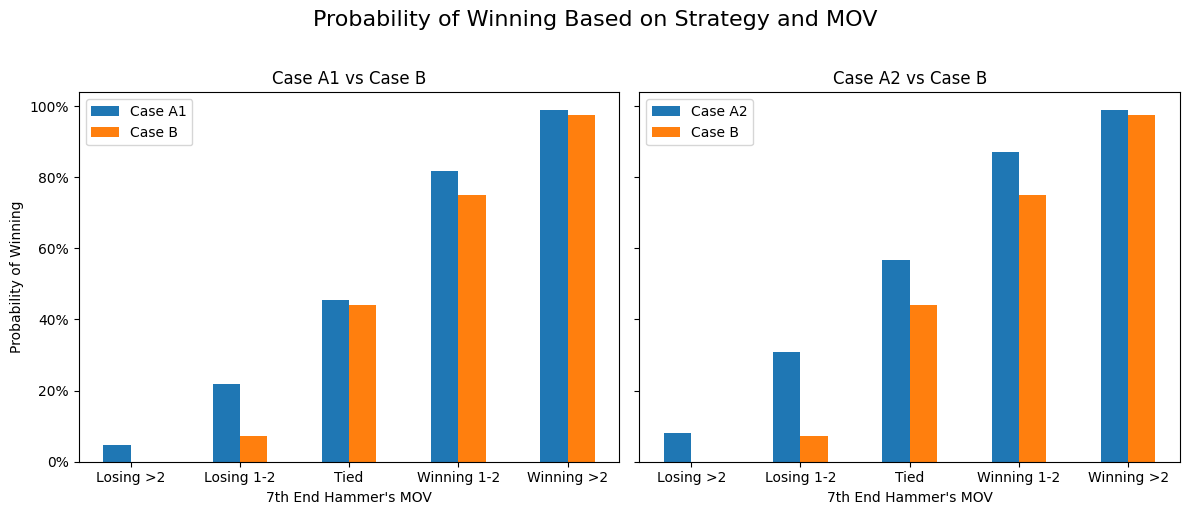

In [37]:
# show both situations next to each other

dfs1 = [case_A_one_df, case_B_df]
dfs2 = [case_A_two_df, case_B_df]

probs1 = pd.DataFrame(
    [(df > 0).mean() for df in dfs1],
    index=["Case A1", "Case B"]
)

probs2 = pd.DataFrame(
    [(df > 0).mean() for df in dfs2],
    index=["Case A2", "Case B"]
)

x = np.arange(len(probs1.columns))
width = 0.25

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# -------- First graph (Case A1 vs B) --------
for i, row in enumerate(probs1.index):
    axes[0].bar(
        x + i * width,
        probs1.loc[row],
        width,
        label=row
    )

axes[0].set_xticks(x + width / 2)
axes[0].set_xticklabels(probs1.columns)
axes[0].set_title("Case A1 vs Case B")
axes[0].set_xlabel("7th End Hammer's MOV")
axes[0].set_ylabel("Probability of Winning")
axes[0].legend()

# -------- Second graph (Case A2 vs B) --------
for i, row in enumerate(probs2.index):
    axes[1].bar(
        x + i * width,
        probs2.loc[row],
        width,
        label=row
    )

axes[1].set_xticks(x + width / 2)
axes[1].set_xticklabels(probs2.columns)
axes[1].set_title("Case A2 vs Case B")
axes[1].set_xlabel("7th End Hammer's MOV")
axes[1].legend()

new_x_labels = ["Losing >2", "Losing 1-2", "Tied", "Winning 1-2", "Winning >2"]

axes[0].set_xticks(x + width / 2)
axes[0].set_xticklabels(new_x_labels)

axes[1].set_xticks(x + width / 2)
axes[1].set_xticklabels(new_x_labels)

axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x*100:.0f}%")
)

fig.suptitle("Probability of Winning Based on Strategy and MOV", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


This figure shows the likelihood of the Power Play Retention Strategy winning the game (Case B) versus electing to use the power play earlier, based on whether the opposing team has a power play remaining (Case A1) or not (Case A2)

Surprisingly, the results were very unfavorable to support sacrificing an end - even when the opposing team had a PP remaining.  Due to limitations in comparable data, we don’t want to make a strong assertion that one strategy is certainly better or worse than another.  If more comparable data became available, it’s very possible that one strategy may clearly prevail over another.  However, it appears today that intentionally sacrificing a point in the 7th end to use the PP in the 8th carries a lot of risk with minimal, if any, upside.

**Rule of Thumb 1: Don’t sacrifice an end to intentionally retain the hammer.**

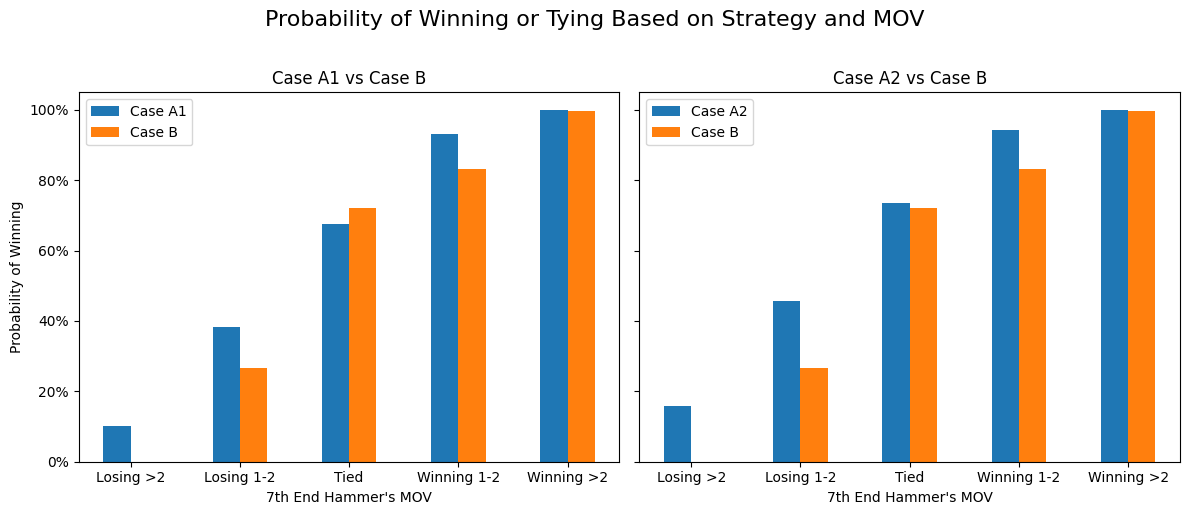

In [38]:
# show both situations next to each other

dfs1 = [case_A_one_df, case_B_df]
dfs2 = [case_A_two_df, case_B_df]

probs1 = pd.DataFrame(
    [(df >= 0).mean() for df in dfs1],
    index=["Case A1", "Case B"]
)

probs2 = pd.DataFrame(
    [(df >= 0).mean() for df in dfs2],
    index=["Case A2", "Case B"]
)

x = np.arange(len(probs1.columns))
width = 0.25

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# -------- First graph (Case A1 vs B) --------
for i, row in enumerate(probs1.index):
    axes[0].bar(
        x + i * width,
        probs1.loc[row],
        width,
        label=row
    )

axes[0].set_xticks(x + width / 2)
axes[0].set_xticklabels(probs1.columns)
axes[0].set_title("Case A1 vs Case B")
axes[0].set_xlabel("7th End Hammer's MOV")
axes[0].set_ylabel("Probability of Winning")
axes[0].legend()

# -------- Second graph (Case A2 vs B) --------
for i, row in enumerate(probs2.index):
    axes[1].bar(
        x + i * width,
        probs2.loc[row],
        width,
        label=row
    )

axes[1].set_xticks(x + width / 2)
axes[1].set_xticklabels(probs2.columns)
axes[1].set_title("Case A2 vs Case B")
axes[1].set_xlabel("7th End Hammer's MOV")
axes[1].legend()

new_x_labels = ["Losing >2", "Losing 1-2", "Tied", "Winning 1-2", "Winning >2"]

axes[0].set_xticks(x + width / 2)
axes[0].set_xticklabels(new_x_labels)

axes[1].set_xticks(x + width / 2)
axes[1].set_xticklabels(new_x_labels)

axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x*100:.0f}%")
)

fig.suptitle("Probability of Winning or Tying Based on Strategy and MOV", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
